In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import concurrent
from copy import deepcopy as copy
def sleep():
    time.sleep(0.2)
def clear_output(wait=True):
    return display.clear_output(wait=wait)

In [2]:
# ! pip install -e ../../savo

In [3]:
import objFuncs
from objFuncs import VM
from objFuncs import maximize_FC
from objFuncs.util import plot_obj_history
from savo import savo

objFuncs version: 1.1.0. updated on 2023-12-04
No Bottleneck unit testing available.


In [5]:
ndim = 100
lim = 2
epoch = 500
n_grad_data_min = 50
x_bounds = [(-lim,lim)]*ndim
max_dx = [0.01]*ndim
noise = 0.02

# obj func

In [6]:
import torch
layers = [
    torch.nn.Linear(ndim,256),torch.nn.ELU(),
    torch.nn.Linear(   256,256),torch.nn.ELU(),
    torch.nn.Linear(   256, 2)
    ]

comp_scaler = 3
compressor = torch.nn.Sequential(*layers)

In [7]:
def rastrigin(x,noise=noise):
    if x.ndim == 1:
        return np.sum(x**2 - np.cos(2*np.pi*x))/len(x)+1
    else:
        b,d = x.shape
        y = np.sum(x**2 - np.cos(2*np.pi*x),axis=1)/d +1
        if d==1:
            return float(y) + np.random.randn()*noise
        else:
            return y + np.random.randn(b)*noise

In [8]:
def obj_func(x):
    return -rastrigin(comp_scaler*compressor(torch.tensor(x.reshape(-1,ndim)).to(torch.float32)).detach().numpy())

In [9]:
vm = VM(
        fun = obj_func,
        x0 = np.zeros(ndim),
        decision_CSETs=['X'+str(i)+':_CSET' for i in range(ndim)],
        objective_RDs = ['rastrigin:_RD'],
        )

In [10]:
objFuncs._global_machineIO.ensure_set = vm.ensure_set
objFuncs._global_machineIO.fetch_data = vm.fetch_data
objFuncs._global_machineIO._test = True

In [11]:
obj0 = maximize_FC.maximize_FC1102(  
    decision_CSETs=vm.decision_CSETs,
    decision_min= -lim,
    decision_max=  lim,
    objective_goal = { 
            'rastrigin:_RD': {'more than': -1},
                           },
    objective_weight = { 
            'rastrigin:_RD' : 1.,     
            },
    objective_norm = { 
            'rastrigin:_RD' : 1.,     
            },
    apply_bilog = False,
    )

======== class info ========
init_time: 2023-12-15 10:44:25.356082
class_hierarchy: [
    maximize_FC1102, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f4fb835bd60>
decision_CSETs : list of shape (100,) and type <U9
decision_min : array of shape (100,) and type float64
decision_max : array of shape (100,) and type float64
decision_bounds : array of shape (100, 2) and type float64
decision_RDs : list of shape (100,) and type <U7
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: FC1102
logging_fname: None
x0 : list of shape (100,) and type float64
objective_weight: {'rastrigin:_RD': 1.0}
objective_goal: {'rastrigin:_RD': {'more than': -1}}
objective_norm: {'rastrigin:_RD': 1.0}
objective_RDs: [
    rastrigin:_RD]
objective_p_order: 2
apply_bilog: False



### initial decision point

In [12]:
obj = copy(obj0)

y0=0
while(y0>-1.9):
    x0 = np.clip(
                    np.float32( np.random.rand(1,ndim)*4-2  
                              ),
                    a_min=-2,a_max=2
                    )
    y0 = np.mean(obj(x0))

In [13]:
x0,y0

(array([[-1.090757  ,  1.6641865 ,  0.7121695 ,  1.7516181 ,  1.4540688 ,
          0.22739884, -1.6800336 ,  0.7101469 ,  0.47752097,  1.3975792 ,
         -0.40572482,  0.8945383 , -1.2796513 ,  1.9517066 ,  0.70788705,
          0.6016891 ,  1.5166776 ,  1.5800816 , -0.61352676,  1.2949973 ,
         -1.291888  ,  1.7008162 , -1.49522   , -0.54765373,  0.68568534,
          1.1106112 ,  1.4100983 ,  0.11155793, -0.6101119 ,  1.896293  ,
         -1.1403106 , -0.8235378 ,  1.5619013 ,  1.6195989 ,  1.5066619 ,
          1.1460043 ,  0.8425611 ,  0.56193227, -1.0035248 ,  0.6680754 ,
          1.2975135 , -1.7156593 ,  0.21538883,  1.5693758 ,  0.19142568,
         -1.6755501 ,  1.5109977 ,  0.6321735 , -0.3916716 , -0.5583262 ,
          0.95298094,  1.2889296 , -0.05149836, -0.16270694, -1.974993  ,
          1.8380642 , -1.2953894 , -1.1342137 ,  1.7781286 ,  1.0462341 ,
          0.89631927, -1.9833642 , -1.8693978 ,  1.2792469 ,  1.7461821 ,
         -0.4563892 , -1.1226193 ,  1.

# run

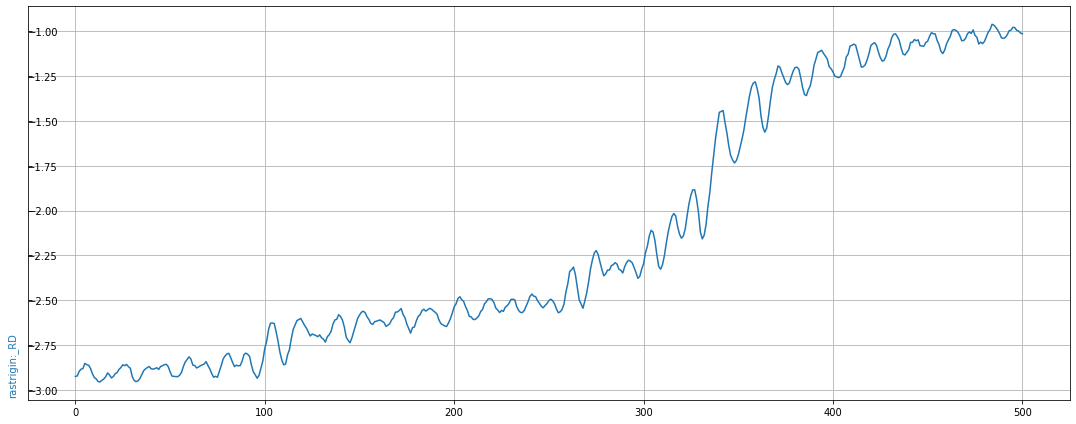

In [14]:
obj = copy(obj0)
plot_RDs = plot_obj_history(
            obj.history['objective_RDs'],
            )
callbacks = [plot_RDs]
def obj_callbacks(x):
#     time.sleep(0.1)
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )
sv.runES(epoch)
plot_RDs.close()

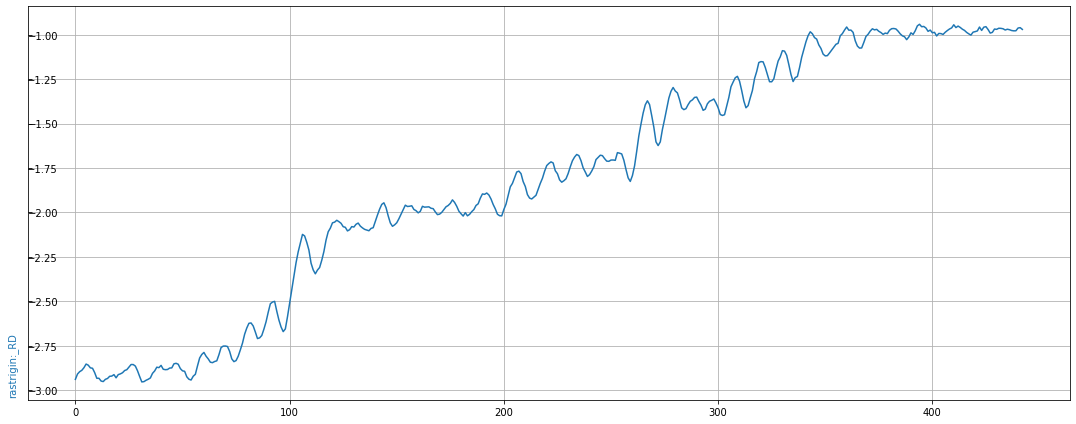

In [ ]:
obj = copy(obj0)
plot_RDs = plot_obj_history(
            obj.history['objective_RDs'],
            )
callbacks = [plot_RDs]
def obj_callbacks(x):
#     time.sleep(0.1)
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )
sv.runES(n_grad_data_min)
sv.run_savo(epoch-n_grad_data_min,lambdaES=1)

plot_RDs.close()

In [ ]:
obj = copy(obj0)
plot_RDs = plot_obj_history(
            obj.history['objective_RDs'],
            )
callbacks = [plot_RDs]
def obj_callbacks(x):
#     time.sleep(0.1)
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )
sv.runES(n_grad_data_min)
sv.run_savo(epoch-n_grad_data_min,lambdaES=0)

plot_RDs.close()